In [29]:
#--------------------------------------------------better_code_below_--_----------------------------------------------------------------------

In [31]:
# Install Libraries
!pip -q install statsbombpy mplsoccer pandas matplotlib numpy


In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsbombpy import sb
from mplsoccer import Pitch

plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', None)

os.makedirs("figs", exist_ok=True)


In [33]:
def _xy(val):
    if isinstance(val, list) and len(val) >= 2:
        return val[0], val[1]
    return (np.nan, np.nan)

def _prep_shots(events):
    shots = events[events['type'] == 'Shot'].copy()
    shots[['x','y']] = shots['location'].apply(lambda v: pd.Series(_xy(v)))
    shots['minute_exact'] = shots['minute'] + shots['second'].fillna(0)/60
    shots['xg'] = shots['shot_statsbomb_xg']
    shots['is_goal'] = (shots['shot_outcome'] == 'Goal').astype(int)
    shots['player'] = shots['player'].apply(lambda x: x.split()[-1] if isinstance(x, str) else x) # Extract last name for labeling
    return shots

def _prep_passes(events):
    passes = events[events['type'] == 'Pass'].copy()
    passes[['x','y']] = passes['location'].apply(lambda v: pd.Series(_xy(v)))
    passes[['end_x','end_y']] = passes['pass_end_location'].apply(lambda v: pd.Series(_xy(v)))
    return passes

def _xg_timeline_plot(shots, home, away, title_stub, savepath=None):
    # cumulative xG & Goals
    timelines = []
    for team in shots['team'].unique():
        s = shots[shots['team'] == team].sort_values('minute_exact').copy()
        s['cum_xg'] = s['xg'].cumsum()
        s['cum_goals'] = s['is_goal'].cumsum()
        s['team'] = team
        timelines.append(s[['minute_exact','cum_xg','cum_goals','team', 'player', 'minute']])
    tl = pd.concat(timelines)

    fig, ax = plt.subplots()
    for team, grp in tl.groupby('team'):
        ax.fill_between(grp['minute_exact'], grp['cum_xg'], step="pre", alpha=0.5, label=f"{team} cum xG")
        ax.step(grp['minute_exact'], grp['cum_goals'], where='post', linestyle='--', label=f"{team} goals")


    # Annotate goals + HT
    for team, grp in tl.groupby('team'):
        goals = grp[grp['cum_goals'].diff().fillna(0) > 0]
        for _, r in goals.iterrows():
            ax.scatter(r['minute_exact'], r['cum_goals'], s=45)
            ax.annotate(f"{r['minute']}' {r['player']}", (r['minute_exact'], r['cum_goals']), textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)

    ax.axvline(45, ls=':', lw=1)
    ax.set_title(f"xG vs Goals — {title_stub}")
    ax.set_xlabel("Match minute")
    ax.set_ylabel("Cumulative")
    ax.legend()
    if savepath:
        fig.savefig(savepath, dpi=200, bbox_inches='tight')
    plt.show()

In [34]:
def _shot_map_plot(shots, home_team, away_team, title_stub, savepath=None):
    pitch = Pitch(pitch_type='statsbomb', line_color='black')
    fig, ax = pitch.draw(figsize=(12, 8)) # Increased figure size for better readability

    # Separate shots by team
    home_shots = shots[shots['team'] == home_team]
    away_shots = shots[shots['team'] == away_team]

    # Plot home team shots
    home_goals = home_shots[home_shots['is_goal'] == 1]
    home_non_goals = home_shots[home_shots['is_goal'] == 0]
    pitch.scatter(home_non_goals['x'], home_non_goals['y'], s=200 * (home_non_goals['xg'].clip(0.05, None)), ax=ax, alpha=0.6, color='blue', label=f"{home_team} Shots")
    pitch.scatter(home_goals['x'], home_goals['y'], s=300 * (home_goals['xg'].clip(0.05, None)), ax=ax, alpha=0.9, marker='*', color='darkblue', label=f"{home_team} Goals")

    # Plot away team shots
    away_goals = away_shots[away_shots['is_goal'] == 1]
    away_non_goals = away_shots[away_shots['is_goal'] == 0]
    pitch.scatter(away_non_goals['x'], away_non_goals['y'], s=200 * (away_non_goals['xg'].clip(0.05, None)), ax=ax, alpha=0.6, color='red', label=f"{away_team} Shots")
    pitch.scatter(away_goals['x'], away_goals['y'], s=300 * (away_goals['xg'].clip(0.05, None)), ax=ax, alpha=0.9, marker='*', color='darkred', label=f"{away_team} Goals")


    # Label goals with xG and player name
    for _, row in home_goals.iterrows():
        ax.annotate(f"{row['player']} ({row['xg']:.2f})", (row['x'], row['y']), textcoords="offset points", xytext=(5, 5), ha='left', fontsize=9)
    for _, row in away_goals.iterrows():
        ax.annotate(f"{row['player']} ({row['xg']:.2f})", (row['x'], row['y']), textcoords="offset points", xytext=(5, 5), ha='left', fontsize=9)


    ax.legend(loc='lower left')
    ax.set_title(f"Shot Map — {title_stub}")
    if savepath:
        fig.savefig(savepath, dpi=200, bbox_inches='tight')
    plt.show()

In [35]:
def _passing_network(passes, team_name, title_stub, period=None, min_passes_link=3, min_player_passes=5, savepath=None):
    tp = passes[(passes['team']==team_name) & (passes['pass_outcome'].isna())].copy()
    if period is not None:
        tp = tp[tp['period']==period]
    tp = tp[tp['pass_recipient'].notna()]
    if tp.empty:
        print(f"[warn] No passes for {team_name} (period={period})")
        return

    avg_loc = tp.groupby('player')[['x','y']].mean()
    edges = (tp.groupby(['player','pass_recipient'])
               .size().reset_index(name='count'))
    edges = edges[edges['count'] >= min_passes_link]

    involvement = (tp['player'].value_counts() + tp['pass_recipient'].value_counts()).fillna(0)
    keep = involvement[involvement >= min_player_passes].index
    avg_loc = avg_loc.loc[avg_loc.index.intersection(keep)]
    edges = edges[edges['player'].isin(keep) & edges['pass_recipient'].isin(keep)]

    pitch = Pitch(pitch_type='statsbomb', line_color='black')
    fig, ax = pitch.draw(figsize=(10,7))
    ptxt = f" (H{period})" if period else ""
    ax.set_title(f"Passing Network — {team_name}{ptxt} | {title_stub}")

    for player, (x, y) in avg_loc.iterrows():
        pitch.scatter(x, y, s=300, ax=ax, edgecolors='black', zorder=3)
        ax.text(x, y, player.split()[-1], ha='center', va='center', fontsize=8, zorder=4)

    for _, row in edges.iterrows():
        if row['player'] in avg_loc.index and row['pass_recipient'] in avg_loc.index:
            x1, y1 = avg_loc.loc[row['player']]
            x2, y2 = avg_loc.loc[row['pass_recipient']]
            lw = 0.5 + 0.5 * row['count']
            pitch.lines(x1, y1, x2, y2, lw=lw, ax=ax, alpha=0.6, zorder=2)

    if savepath:
        fig.savefig(savepath, dpi=200, bbox_inches='tight')
    plt.show()

def _quick_tables(shots):
    team_shots = shots.groupby('team').agg(
        shots=('id', 'count'),
        goals=('is_goal', 'sum'),
        xg=('xg', 'sum')
    ).reset_index()

    player_perf = shots.groupby(['team','player']).agg(
        shots=('id','count'),
        goals=('is_goal','sum'),
        xg=('xg','sum')
    ).reset_index()
    player_perf['delta_goals_xg'] = player_perf['goals'] - player_perf['xg']
    return team_shots, player_perf

def _flank_bias(passes, team_name):
    tpasses = passes[(passes['team']==team_name) & (passes['pass_outcome'].isna())]
    if tpasses.empty or tpasses['y'].isna().all():
        return None
    y = tpasses['y'].dropna()
    left_share = (y < 40).mean()  # simple split; modify to thirds if you like
    right_share = 1 - left_share
    side = "left" if left_share > right_share else "right"
    return side, max(left_share, right_share)

def _title_from_match(md):
    return f"{md['home_team']} {md['home_score']}–{md['away_score']} {md['away_team']} ({md['competition']}, {md['match_date']})"


In [36]:
def analyze_match(match_id, outdir="figs", by_halves=True, save_png=True, verbose=True):
    """
    Analyze any StatsBomb open-data match and export:
      - xG timeline
      - team shot maps
      - passing networks (by half if by_halves=True)
      - quick coaching notes (printed)
    """
    # Pull match meta (for nice titles/filenames)
    # Try to infer competition/season from all open-data comps:
    md = None
    for comp in sb.competitions().itertuples():
        try:
            ms = sb.matches(competition_id=comp.competition_id, season_id=comp.season_id)
            r = ms[ms['match_id']==match_id]
            if len(r)==1:
                row = r.iloc[0]
                md = {
                    'home_team': row.home_team,
                    'away_team': row.away_team,
                    'home_score': int(row.home_score),
                    'away_score': int(row.away_score),
                    'match_date': row.match_date,
                    'competition': comp.competition_name
                }
                break
        except Exception:
            continue
    if md is None:
        # Fallback minimal meta
        md = {'home_team':'Home','away_team':'Away','home_score':'','away_score':'','match_date':'', 'competition':'Open Data'}

    title_stub = _title_from_match(md)

    # Load events
    events = sb.events(match_id=match_id)
    shots = _prep_shots(events)
    passes = _prep_passes(events)

    # Basic names
    teams = list(shots['team'].dropna().unique())
    if len(teams) < 2:
        # fallback to team names present in passes
        teams = list(passes['team'].dropna().unique())
    if len(teams) < 2 and verbose:
        print("[warn] Could not infer both team names from events.")
    home, away = (teams + [None, None])[:2]

    # Plots
    xg_path = f"{outdir}/xg_timeline_{match_id}.png" if save_png else None
    _xg_timeline_plot(shots, home, away, title_stub, savepath=xg_path)

    # Modified to pass home and away team names
    sm_path = f"{outdir}/shotmap_{md['home_team'].replace(' ','_')}_vs_{md['away_team'].replace(' ','_')}_{match_id}.png" if save_png else None
    _shot_map_plot(shots, md['home_team'], md['away_team'], title_stub, savepath=sm_path)


    for t in teams:
        if by_halves:
            for p in (1,2):
                pn_path = f"{outdir}/passnet_H{p}_{t.replace(' ','_')}_{match_id}.png" if save_png else None
                _passing_network(passes, t, title_stub, period=p, savepath=pn_path)
        else:
            pn_path = f"{outdir}/passnet_{t.replace(' ','_')}_{match_id}.png" if save_png else None
            _passing_network(passes, t, title_stub, period=None, savepath=pn_path)

    # Tables + quick notes
    team_shots, player_perf = _quick_tables(shots)
    if verbose:
        print("\n=== Team Summary ===")
        display(team_shots.sort_values('xg', ascending=False).reset_index(drop=True))
        print("\n=== Player Over/Under vs xG (Top 10 by xG) ===")
        display(player_perf.sort_values('xg', ascending=False).head(10).reset_index(drop=True))

        # Coaching notes (simple stubs)
        print("\nCoaching notes (draft):")
        for t in teams:
            fb = _flank_bias(passes, t)
            if fb:
                print(f"• {t}: Build-up skewed to the {fb[0]} (~{fb[1]*100:.0f}%).")
        for _, row in team_shots.iterrows():
            print(f"• {row['team']}: Goals {row['goals']} vs xG {row['xg']:.2f} "
                  f"({row['goals']-row['xg']:+.2f}).")

    return {
        "meta": md,
        "teams": teams,
        "team_summary": team_shots,
        "player_summary": player_perf
    }

In [37]:
# optional Convenience: pick a match by teams (WC 2018)

def get_wc2018_match_id(home=None, away=None, date=None):
    comp_id, season_id = 43, 3
    ms = sb.matches(competition_id=comp_id, season_id=season_id)
    df = ms.copy()
    if home: df = df[df['home_team']==home]
    if away: df = df[df['away_team']==away]
    if date: df = df[df['match_date']==date]
    if len(df)==0:
        raise ValueError("No match found with given filters.")
    if len(df)>1:
        print("Multiple matches found; returning the first. Candidates:")
        display(df[['match_id','home_team','away_team','match_date']])
    return int(df.iloc[0].match_id)


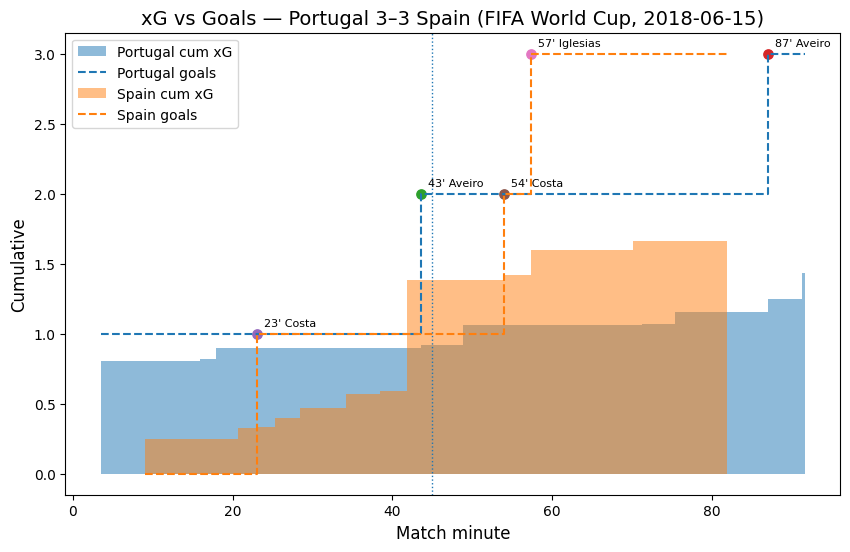

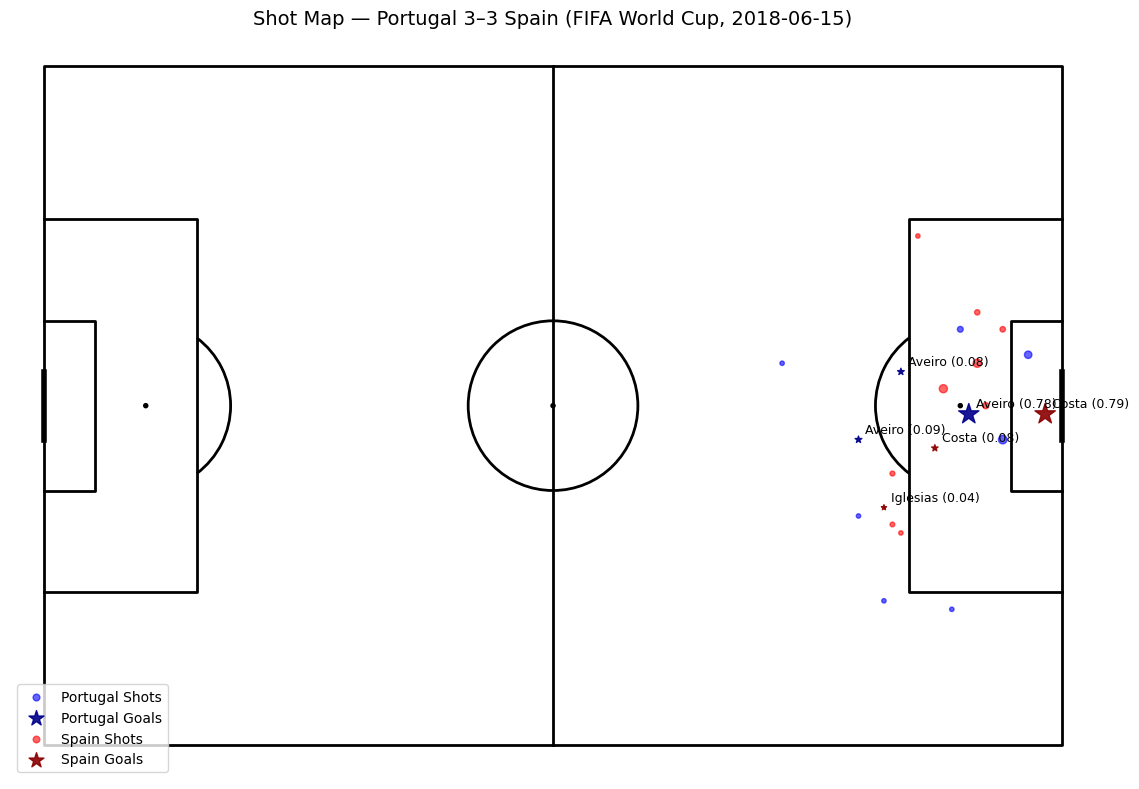

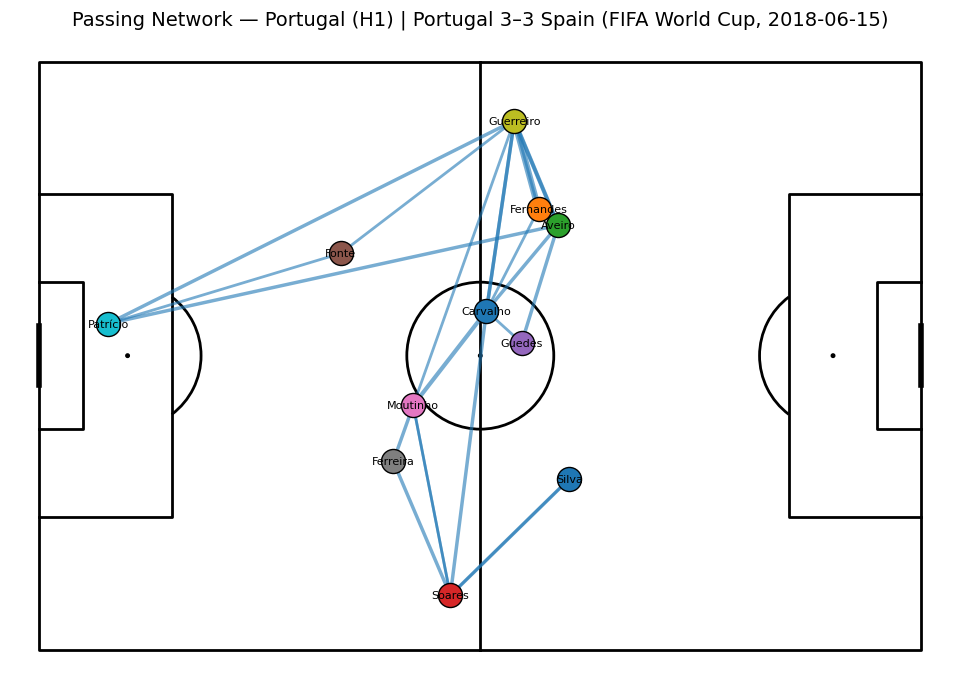

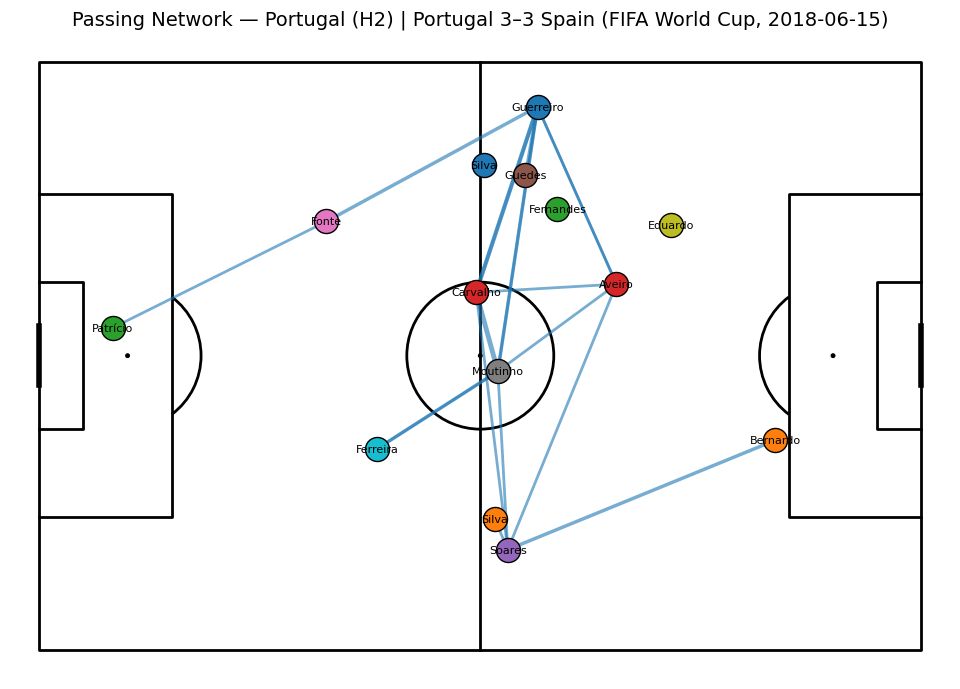

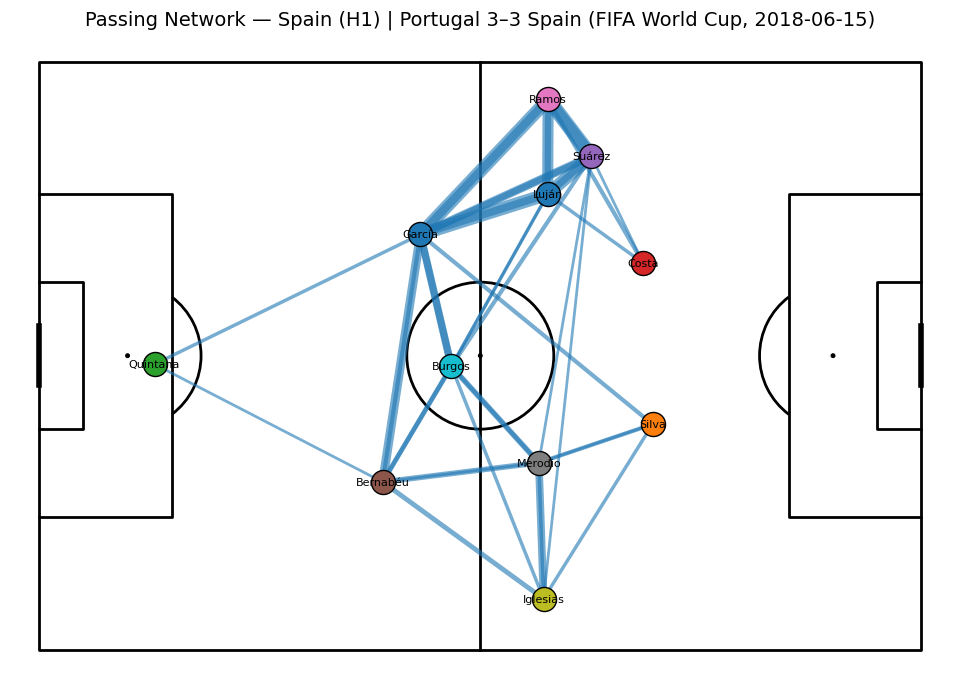

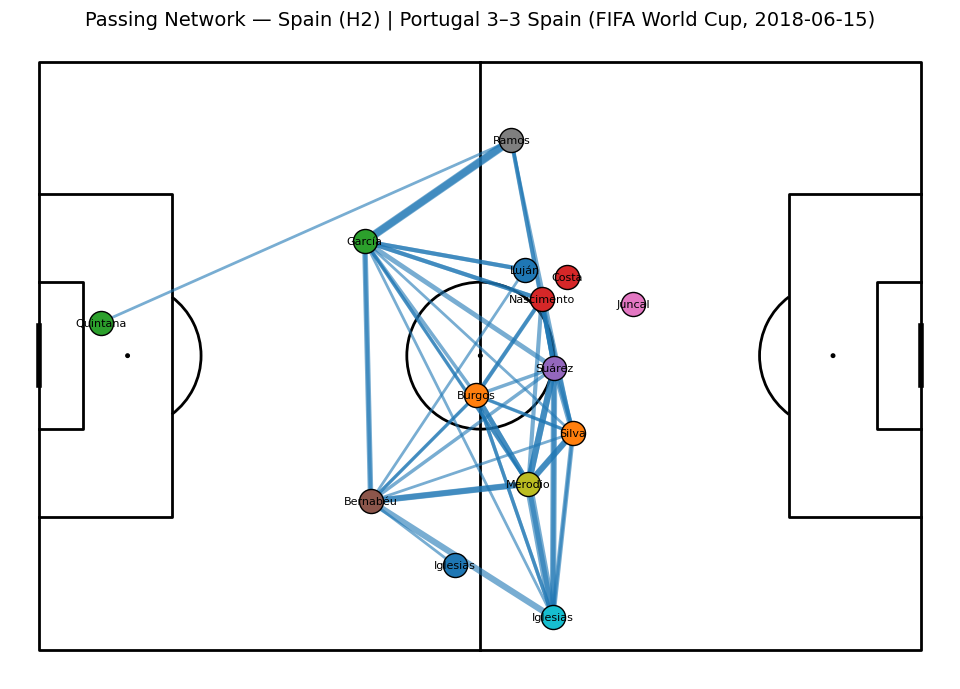


=== Team Summary ===


,team,shots,goals,xg
0,Spain,12,3,1.660947
1,Portugal,10,3,1.434596



=== Player Over/Under vs xG (Top 10 by xG) ===


,team,player,shots,goals,xg,delta_goals_xg
0,Portugal,Aveiro,5,3,1.152356,1.847644
1,Spain,Costa,3,2,1.046944,0.953056
2,Spain,Silva,3,0,0.307189,-0.307189
3,Portugal,Ferreira,1,0,0.142786,-0.142786
4,Spain,Burgos,1,0,0.100478,-0.100478
5,Portugal,Bernardo,2,0,0.094764,-0.094764
6,Spain,Luján,1,0,0.073567,-0.073567
7,Spain,Juncal,1,0,0.062863,-0.062863
8,Spain,Iglesias,1,1,0.035519,0.964481
9,Spain,Suárez,2,0,0.034386,-0.034386



Coaching notes (draft):
• Portugal: Build-up skewed to the left (~60%).
• Spain: Build-up skewed to the left (~56%).
• Portugal: Goals 3 vs xG 1.43 (+1.57).
• Spain: Goals 3 vs xG 1.66 (+1.34).


In [38]:
# Example A: Spain–Portugal (Group Stage, WC 2018)
match_id = get_wc2018_match_id(home="Portugal", away="Spain")
result = analyze_match(match_id, by_halves=True, save_png=True)

# Example B: France–Argentina (Round of 16, WC 2018)
# match_id = get_wc2018_match_id(home="France", away="Argentina")
# result = analyze_match(match_id)
